<a href="https://colab.research.google.com/github/vaniizzz/SequentialTest_EXXA5/blob/main/SequentialTest_EXXA5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install numpy matplotlib scikit-learn tensorflow


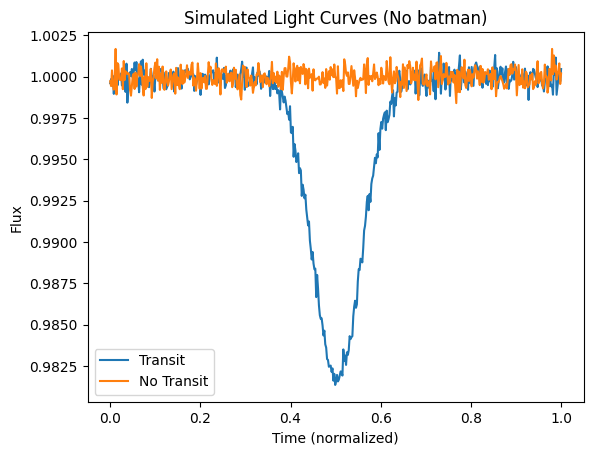

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def generate_light_curve(has_transit=True, noise_level=0.0005):
    t = np.linspace(0, 1, 500)  # normalized time in phase
    flux = np.ones_like(t)      # default flux = 1 (flat)

    if has_transit:
        transit_center = 0.5 + np.random.uniform(-0.05, 0.05)
        transit_width = 0.05 + np.random.uniform(0, 0.02)
        transit_depth = 0.01 + np.random.uniform(0, 0.01)

        # Gaussian transit shape
        transit = transit_depth * np.exp(-0.5 * ((t - transit_center) / transit_width) ** 2)
        flux -= transit

    # Add Gaussian noise
    noise = np.random.normal(0, noise_level, size=flux.shape)
    noisy_flux = flux + noise

    return t, noisy_flux, int(has_transit)

# Plot samples
for has_transit in [True, False]:
    t, flux, label = generate_light_curve(has_transit)
    plt.plot(t, flux, label="Transit" if label else "No Transit")
plt.xlabel("Time (normalized)")
plt.ylabel("Flux")
plt.title("Simulated Light Curves (No batman)")
plt.legend()
plt.show()


In [5]:
def create_dataset(n_samples=2000):
    X, y = [], []
    for _ in range(n_samples):
        has_transit = np.random.choice([True, False])
        _, flux, label = generate_light_curve(has_transit)
        X.append(flux)
        y.append(label)
    return np.array(X), np.array(y)

X, y = create_dataset(2000)
X = X[..., np.newaxis]  # For CNN input


In [8]:
!pip install scikit-learn matplotlib

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [10]:
def generate_light_curve(with_transit, time, transit_depth=0.02, transit_duration=0.1, noise_level=0.0003):
    flux = np.ones_like(time)
    if with_transit:
        period = np.random.uniform(0.5, 1.0)
        phase = np.random.uniform(0, 1)
        transit_center = period * phase
        in_transit = np.abs(time - transit_center) < (transit_duration / 2)
        flux[in_transit] -= transit_depth
    flux += np.random.normal(0, noise_level, size=flux.shape)
    return flux

In [11]:
num_samples = 2000
time = np.linspace(0, 1, 200)
X = []
y = []

for _ in range(num_samples // 2):
    X.append(generate_light_curve(True, time))
    y.append(1)

for _ in range(num_samples // 2):
    X.append(generate_light_curve(False, time))
    y.append(0)

X = np.array(X)
y = np.array(y)
X = X[..., np.newaxis]  # Add channel dimension for CNN

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
model = Sequential([
    Conv1D(32, kernel_size=5, activation='relu', input_shape=X.shape[1:]),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32)

Epoch 1/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9127 - loss: 0.1743 - val_accuracy: 0.4563 - val_loss: 5.4335
Epoch 2/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 1.0000 - loss: 1.0628e-04 - val_accuracy: 0.4563 - val_loss: 5.4358
Epoch 3/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 1.0000 - loss: 3.3651e-05 - val_accuracy: 0.4563 - val_loss: 5.5433
Epoch 4/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 4.8634e-05 - val_accuracy: 0.4563 - val_loss: 5.6640
Epoch 5/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 3.2586e-05 - val_accuracy: 0.4563 - val_loss: 5.6921
Epoch 6/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 2.9353e-05 - val_accuracy: 0.4563 - val_loss: 5.9406
Epoch 7/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 2.0570e-05 - val_accuracy: 0.4563 - val_loss: 6.2716
Epoch 8/30
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 5.8814e-0

In [15]:
y_pred_prob = model.predict(X_test).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


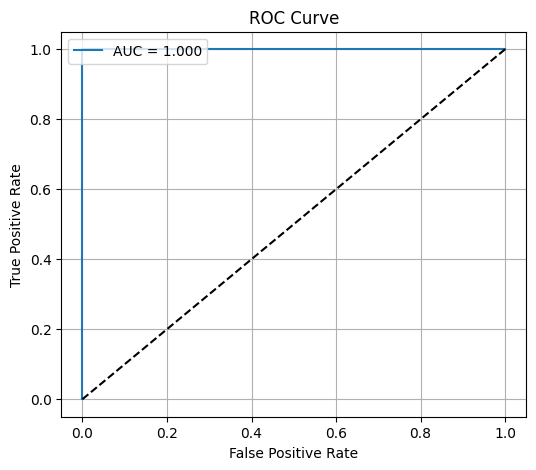

In [16]:
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


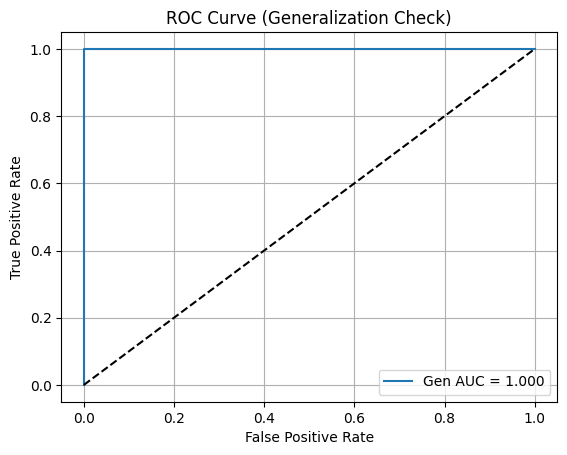

In [17]:
import random

num_samples = 100
X_gen = []
y_gen = []

for _ in range(num_samples):
    is_transit = random.choice([True, False])
    if is_transit:
        flux = generate_light_curve(
            True,
            time,
            transit_depth=np.random.uniform(0.005, 0.02),  # more variation
            noise_level=np.random.uniform(0.0008, 0.002)   # slightly higher noise
        )
        y_gen.append(1)
    else:
        flux = generate_light_curve(
            False,
            time,
            noise_level=np.random.uniform(0.0008, 0.002)
        )
        y_gen.append(0)

    X_gen.append(flux)

# Preprocess
X_gen = np.array(X_gen).reshape(-1, len(time), 1)
y_gen = np.array(y_gen)

# Predict
y_gen_pred = model.predict(X_gen).ravel()

# Plot ROC and compute AUC
fpr_gen, tpr_gen, _ = roc_curve(y_gen, y_gen_pred)
roc_auc_gen = auc(fpr_gen, tpr_gen)

plt.figure()
plt.plot(fpr_gen, tpr_gen, label=f'Gen AUC = {roc_auc_gen:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (Generalization Check)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [18]:
!pip install lightkurve


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.4/270.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.6/997.6 kB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 67.1 MB/s eta 0:00:00
  Created wheel for fbpca: filename=fbpca-1.0-py3-none-any.whl size=11373 sha256=bfa83f6ad8f0dc9ff95d5bde05fd9537ab509a27d9ea99057e18c4edafd3f6de
  Stored in directory: /root/.cache/pip/wheels/71/ae/f7/5b7e1e16a133d094431428169e9a8d9f750afe5459f0333c9b
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-

In [19]:
from lightkurve import search_lightcurve

# Search for a star with a known exoplanet (like Kepler-10)
search_result = search_lightcurve("Kepler-10", mission="Kepler", cadence="long")
lc = search_result.download()


/usr/local/lib/python3.11/dist-packages/lightkurve/search.py:424: LightkurveWarning: Warning: 16 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

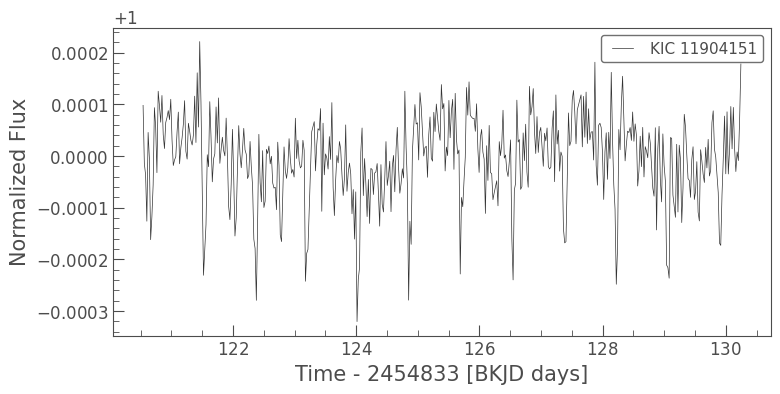

In [20]:
# Remove NaNs, normalize flux
lc = lc.remove_nans().normalize()

# Flatten (optional): removes stellar variability
lc_flat = lc.flatten(window_length=401)

# Plot the observational light curve
lc_flat.plot()


In [21]:
flux = lc_flat.flux.value
time = lc_flat.time.value

# Resize to your model's expected input length
desired_length = X.shape[1]  # use length of your synthetic data
if len(flux) > desired_length:
    flux = flux[:desired_length]
else:
    flux = np.pad(flux, (0, desired_length - len(flux)), mode='edge')

flux = np.array(flux).reshape(1, -1, 1)  # match model input


In [22]:
prob = model.predict(flux)[0][0]
print(f"Predicted probability of transit: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted probability of transit: 0.0000


In [28]:
from lightkurve import search_lightcurve
import numpy as np

X_obs = []
y_obs = []
desired_length = 200  # match with your model input shape
targets = ["Kepler-10", "Kepler-20", "Kepler-90"]

for target in targets:
    try:
        search_result = search_lightcurve(target, mission="Kepler", cadence="long")
        lc = search_result[0].download().remove_nans().normalize().flatten()

        flux = lc.flux.value
        flux = np.ma.filled(flux, np.nan)  # handles both masked and normal arrays

        # Pad or trim
        if len(flux) < desired_length:
            flux = np.pad(flux, (0, desired_length - len(flux)), mode='edge')
        else:
            flux = flux[:desired_length]

        X_obs.append(flux)
        y_obs.append(1)

    except Exception as e:
        print(f"Skipping {target} due to error: {e}")


In [29]:
X_obs = np.array(X_obs).reshape(-1, desired_length, 1)
y_obs = np.array(y_obs)


In [30]:
X_test_combined = np.concatenate([X_test, X_obs], axis=0)
y_test_combined = np.concatenate([y_test, y_obs], axis=0)

y_pred_combined = model.predict(X_test_combined)
fpr, tpr, _ = roc_curve(y_test_combined, y_pred_combined)
auc_combined = auc(fpr, tpr)

print(f"AUC with real + synthetic: {auc_combined:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
AUC with real + synthetic: 1.0000


In [32]:
from sklearn.metrics import roc_auc_score, roc_curve

def run_inference(model, X_test, y_test, title='ROC Curve'):
    y_pred_probs = model.predict(X_test).ravel()

    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    auc_score = roc_auc_score(y_test, y_pred_probs)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return auc_score


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


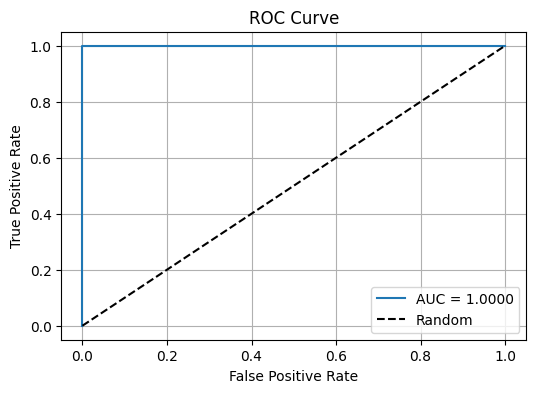

np.float64(1.0)

In [40]:
run_inference(model, X_test, y_test, title='ROC Curve')

In [35]:
# -------------------------------
# 🔍 Run on Withheld Data
# -------------------------------

from google.colab import files
import os

def load_withheld_data():
    print("Please upload your `X_withheld.npy` or `X_withheld.csv` (required)")
    print("Optional: upload `y_withheld.npy` or `y_withheld.csv` if you want AUC evaluation")

    uploaded = files.upload()
    x_file, y_file = None, None

    for fname in uploaded.keys():
        if "x_withheld" in fname.lower():
            x_file = fname
        elif "y_withheld" in fname.lower():
            y_file = fname

    # Load X
    if x_file is None:
        print("X_withheld data not found. Cannot proceed.")
        return None, None
    elif x_file.endswith(".npy"):
        X_withheld = np.load(x_file)
    elif x_file.endswith(".csv"):
        X_withheld = pd.read_csv(x_file).values
    else:
        print(" Unsupported X file type.")
        return None, None

    # Load y (optional)
    y_withheld = None
    if y_file:
        if y_file.endswith(".npy"):
            y_withheld = np.load(y_file)
        elif y_file.endswith(".csv"):
            y_withheld = pd.read_csv(y_file).values.ravel()
        else:
            print("Unsupported y file type. Skipping AUC evaluation.")

    return X_withheld, y_withheld

# Load and Run
X_withheld, y_withheld = load_withheld_data()

if X_withheld is not None:
    print("\n🚀 Running inference on withheld data...")
    predictions = model.predict(X_withheld)

    if y_withheld is not None:
        auc_withheld = roc_auc_score(y_withheld, predictions)
        print(f"AUC on withheld data: {auc_withheld:.4f}")
        fpr, tpr, _ = roc_curve(y_withheld, predictions)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'AUC = {auc_withheld:.4f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve - Withheld Data")
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Inference complete. No ground-truth labels found, skipping AUC.")
else:
    print("Skipped inference due to missing data.")


Please upload your `X_withheld.npy` or `X_withheld.csv` (required)
Optional: upload `y_withheld.npy` or `y_withheld.csv` if you want AUC evaluation


X_withheld data not found. Cannot proceed.
Skipped inference due to missing data.


In [36]:
def plot_sample_curves(X_synthetic, X_real, num_samples=3):
    plt.figure(figsize=(12, 4))
    for i in range(num_samples):
        plt.subplot(2, num_samples, i+1)
        plt.plot(X_synthetic[i])
        plt.title(f"Synthetic #{i+1}")
        plt.grid(True)

        plt.subplot(2, num_samples, num_samples+i+1)
        plt.plot(X_real[i])
        plt.title(f"Real #{i+1}")
        plt.grid(True)
    plt.tight_layout()
    plt.show()


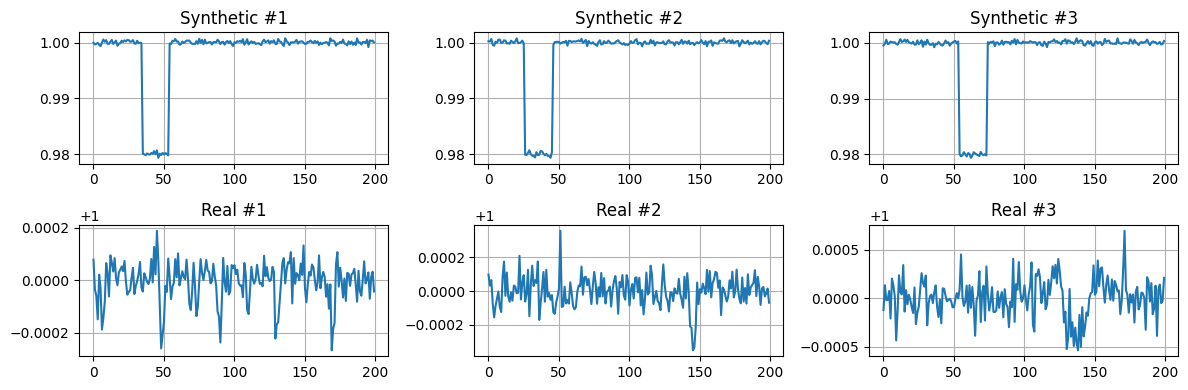

In [37]:
plot_sample_curves(X_synthetic=X[:3], X_real=X_obs[:3])